# Comparison non weighted butterfly

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/lachermeier/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/lachermeier/master_thesis_qaoa/ibm/'))
sys.path.insert(0, os.path.abspath('/home/lachermeier/master_thesis_qaoa/ibm/landscape/'))
sys.path.insert(0, os.path.abspath('/home/lachermeier/master_thesis_qaoa/ibm/landscape/simulator/'))

In [4]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

from ibm_landscape_processes import *

ibmqfactory.load_account:WARNING:2021-09-06 15:43:02,205: Credentials are already in use. The existing account in the session will be replaced.


ModuleNotFoundError: No module named 'shared'

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=False)
opt_max_cut = -4
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

# GoemansWilliamson Solution


In [ ]:
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

In [ ]:
optimizer = GoemansWilliamsonOptimizer(5)
result = optimizer.solve(max_cut_qubo)
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

In [ ]:
qaoa = create_qaoa(initial_point=[1.26, -2.54,])
result, _ = run_qaoa(qaoa, max_cut_qubo)
mean, r, ar = max_cut.analyse_evaluation(result, print_output=True)


# Display MaxCut-Landscape for p = 1

In [29]:
from landscape_helper import *

In [23]:
landscape_results_filename = f"landscape_simulator_{graph.name}_results.npy"

In [24]:
landscape = load_landscape_data(landscape_results_filename, max_cut)

In [25]:
min_beta, min_gamma, min_exp = describe_landscape(landscape)

Landscape mean: -2.63
Min Exp.Value: -3.94
Min. Beta: 1.26, Min. Gamma: -2.54


In [30]:
from plot_helper import *

In [27]:
# Plot landscape in 3D 
plot_landscape_3d(landscape)

In [33]:
# Plot Heatmap 
heatmap = plot_heatmap(landscape)
heatmap = display_minimum(heatmap, min_beta, min_gamma, min_exp)

### Find init values with TQA

In [45]:
from tqa import calculate_tqa

In [46]:
p = 1

In [47]:
tqa_initial_points = calculate_tqa(graph, p)

TQA: Beta: [1.26507538], Gamma: [1.26507538] (p=1)


#### Run QAOA with init_points, different optimizers and plot results 

In [48]:
from qaoa_helper import *

In [49]:
qnSpsa = QNSPSA(calculate_fidelity(create_qaoa(), max_cut_qubo), maxiter=50)
optimizers = [
    ('COBYLA',COBYLA(maxiter=50)),
    ('SPSA', SPSA(maxiter=50)),
    ('QNSPSA', qnSpsa),
]

COBYLA Optimizer
optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -3.890999999999999
Highest Exp.Value: 0 with 1.5375 %
Lowest Exp.Value: -4 with 96.088 %
Highest Probability: -4 with 96.088 %
Ratio r: 0.9727499999999998
Approiximation ratio: 0.9727499999999998
MSE: 6.242547666666663
RMSE: 2.4985090887700734


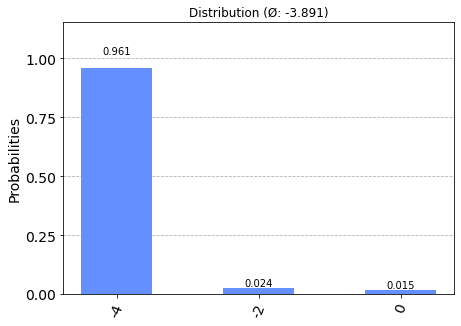

SPSA Optimizer
optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -3.924499999999999
Highest Exp.Value: 0 with 0.7875 %
Lowest Exp.Value: -4 with 97.012 %
Highest Probability: -4 with 97.012 %
Ratio r: 0.9811249999999998
Approiximation ratio: 0.9811249999999998
MSE: 6.370366916666664
RMSE: 2.5239585806163034


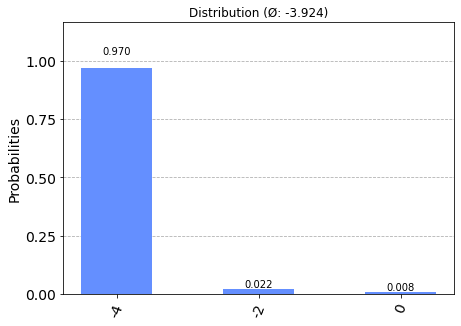

QNSPSA Optimizer
optimal function value: -4.0
optimal value: [1. 1. 0. 0. 0.]
status: SUCCESS
Number of samples (32) is too large to display. Skip.
Expectation Value: -3.9185
Highest Exp.Value: 0 with 1.1125 %
Lowest Exp.Value: -4 with 97.03699999999999 %
Highest Probability: -4 with 97.03699999999999 %
Ratio r: 0.979625
Approiximation ratio: 0.979625
MSE: 6.347308916666666
RMSE: 2.5193866151638313


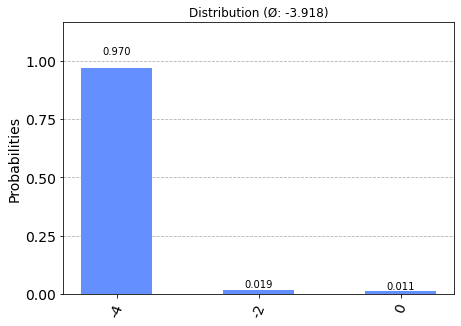

In [51]:
for optimizer_tuple in optimizers:
    optimizer_name, optimizer = optimizer_tuple
    # create qaoa 
    qaoa = create_qaoa(optimizer = optimizer,
            reps=p,
            initial_point=tqa_initial_points,
            with_callback=True
           )
    # run qaoa 
    result, optimal_parameters, optimizer_history = run_qaoa_with_callback(qaoa, max_cut_qubo)
    
    # analyse results 
    print(f"{optimizer_name} Optimizer")
    mean, distribution = max_cut.analyse(result, print_output=True)
    max_cut.plot_histogram(distribution, mean)
    optimizer_history[2][-1] = mean
    print()
    
    # Display Optimizer Results
    counts, energy_values, maxcut_values, optimizer_gammas, optimizer_betas = optimizer_history
    display_optimizer_path(heatmap, optimizer_gammas, optimizer_betas, maxcut_values, optimizer_name)
    
    # Plot Optimizer History MaxCut Evaluation # Values from landscape -> real values may deviate 
    plot_optimizer_maxcut_history(counts, maxcut_values, optimizer_name)
    
    # Plot Optimizer History Energy Evaluation -> not MaxCutMean! 
    plot_optimizer_energy_history(counts, energy_values, optimizer_name)
    

# Comparison

## Parameters

In [ ]:
eval_num = 50
max_p = 10
all_results = {}

## QAOA

In [ ]:
from qaoa_helper import *

In [ ]:
qaoa_p_means = []
qaoa_p_ratios = []
qaoa_p_approx_ratios = []

for p in range(1,max_p+1):
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p)
    qaoa_p_means.append(m)
    qaoa_p_ratios.append(r)
    qaoa_p_approx_ratios.append(ar)

all_results["QAOA"] = [qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios]

In [ ]:
display_boxplots_results(qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios)

## QAOA with TQA

In [ ]:
from qaoa_helper import *

In [ ]:
tqa_p_means = []
tqa_p_ratios = []
tqa_p_approx_ratios = []
tqa_init_points = []

for p in range(1,max_p+1):
    tqa_initial_points = calculate_tqa(graph, p)
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, init_points=tqa_initial_points)
    tqa_p_means.append(m)
    tqa_p_ratios.append(r)
    tqa_p_approx_ratios.append(ar)
    tqa_init_points.append(tqa_initial_points)
    
all_results["TQA QAOA"] = [tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, tqa_init_points]

In [ ]:
display_boxplots_results(tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, prefix='TQA ')

## WarmStart QAOA

In [ ]:
from warmstart_helper import *

In [ ]:
ws_p_means = []
ws_p_ratios = []
ws_p_approx_ratios = []
ws_opt_epsilons = []

for p in range(1,max_p+1):
    opt_epsilon = optimize_epsilon(max_cut, reps=p)
    m, r, ar = start_ws_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, epsilon=opt_epsilon)
    ws_p_means.append(m)
    ws_p_ratios.append(r)
    ws_p_approx_ratios.append(ar)
    ws_opt_epsilons.append(opt_epsilon)
    
all_results["WarmStart QAOA"] = [ws_p_means, ws_p_ratios, ws_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_p_means, ws_p_ratios, ws_p_approx_ratios, prefix='WarmStart ')

### Recursive QAOA

In [ ]:
from recursive_qaoa_helper import *

In [ ]:
recursive_p_means = []
recursive_p_ratios = []
recursive_p_approx_ratios = []

for p in range(1,max_p+1):
    m, r, ar = start_recursive_evaluation(max_cut, eval_num=eval_num, reps=p)
    recursive_p_means.append(m)
    recursive_p_ratios.append(r)
    recursive_p_approx_ratios.append(ar)

all_results["Recursive QAOA"] = [recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios]

In [ ]:
display_boxplots_results(recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios, prefix='Recursive ')

### Recursive WarmStart QAOA

In [ ]:
from recursive_ws_helper import *

In [ ]:
ws_recursive_p_means = []
ws_recursive_p_ratios = []
ws_recursive_p_approx_ratios = []

for p in range(1,max_p+1):
    opt_epsilon = ws_opt_epsilons[p-1]
    m, r, ar = start_recursive_ws_qaoa_evaluation(max_cut, eval_num=eval_num, reps=p, epsilon=opt_epsilon)
    ws_recursive_p_means.append(m)
    ws_recursive_p_ratios.append(r)
    ws_recursive_p_approx_ratios.append(ar)
    
all_results["Recursive WarmStrart QAOA"] = [ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, prefix='Recursive WarmStart ')

## Results

In [ ]:
# Save results 
with open(f'comparison_simulator_{graph.name}_results.npy', 'wb') as f:
    np.save(f, all_results)

In [11]:
from results_helper import *

In [12]:
means_df, ratio_df, approx_ratios_df = generate_dataframes(all_results)

QAOA
TQA QAOA
WarmStart QAOA
Recursive QAOA
Recursive WarmStrart QAOA


### Metric Mean

In [13]:
means_df

,QAOA,TQA QAOA,WarmStart QAOA,Recursive QAOA,Recursive WarmStrart QAOA
p,,,,,
1,-3.91,-3.92,-4.0,-4.0,-4.0
2,-3.90,-3.93,-4.0,-4.0,-4.0
3,-3.91,-3.82,-4.0,-4.0,-4.0
4,-3.91,-3.78,-4.0,-4.0,-4.0
5,-3.92,-3.94,-4.0,-4.0,-4.0
6,-3.90,-3.95,-4.0,-4.0,-4.0
7,-3.91,-3.93,-4.0,-4.0,-4.0
8,-3.87,-3.93,-4.0,-4.0,-4.0
9,-3.87,-3.95,-4.0,-4.0,-4.0


### Metric Ratio 

In [14]:
ratio_df

,QAOA,TQA QAOA,WarmStart QAOA,Recursive QAOA,Recursive WarmStrart QAOA
p,,,,,
1,0.98,0.98,0.0,0.0,0.0
2,0.97,0.98,0.0,0.0,0.0
3,0.98,0.95,0.0,0.0,0.0
4,0.98,0.94,0.0,0.0,0.0
5,0.98,0.98,0.0,0.0,0.0
6,0.98,0.99,0.0,0.0,0.0
7,0.98,0.98,0.0,0.0,0.0
8,0.97,0.98,0.0,0.0,0.0
9,0.97,0.99,0.0,0.0,0.0


### Metric Approximation Ratio

In [15]:
approx_ratios_df

,QAOA,TQA QAOA,WarmStart QAOA,Recursive QAOA,Recursive WarmStrart QAOA
p,,,,,
1,0.98,0.98,1.0,1.0,1.0
2,0.97,0.98,1.0,1.0,1.0
3,0.98,0.95,1.0,1.0,1.0
4,0.98,0.94,1.0,1.0,1.0
5,0.98,0.98,1.0,1.0,1.0
6,0.98,0.99,1.0,1.0,1.0
7,0.98,0.98,1.0,1.0,1.0
8,0.97,0.98,1.0,1.0,1.0
9,0.97,0.99,1.0,1.0,1.0
